In [1]:
!python -V

Python 3.9.6


In [2]:
!pip install pandas==1.2.5 pandas_datareader yfinance==0.1.62 ipywidgets pandas_market_calendars matplotlib numpy pycorrelate


In [3]:
import os
from datetime import datetime
import concurrent
import pandas_datareader.data as web
import pandas as pd
import datetime
import concurrent.futures
from concurrent.futures import wait, ALL_COMPLETED
import yfinance as yf
import urllib
import urllib.request
import time
from datetime import timedelta
from finquant.portfolio import build_portfolio

from ipywidgets import interactive
import numpy as np

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import pycorrelate as pyc
import seaborn as sns
from yahoofinancials import YahooFinancials

import pandas_market_calendars as mcal
import re
from sklearn.model_selection import train_test_split

from scipy import stats # For in-built method to get PCC
from scipy.ndimage.interpolation import shift

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
#import statsmodels.formula.api as sm
import scipy.stats  as stats
from itertools import cycle
import matplotlib.pyplot as plt

In [4]:
def split_sequences(sequences, n_steps_in, n_steps_out):

    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

def crosscorrelation(x, y, maxlag, mode='corr'):
	"""
	Cross correlation with a maximum number of lags.

	`x` and `y` must be one-dimensional numpy arrays with the same length.

	This computes the same result as
		numpy.correlate(x, y, mode='full')[len(a)-maxlag-1:len(a)+maxlag]

	The return vaue has length 2*maxlag + 1.
	"""
	py = np.pad(y.conj(), 2*maxlag, mode='constant')
	T = np.lib.stride_tricks.as_strided(py[2*maxlag:], shape=(2*maxlag+1, len(y) + 2*maxlag),
				   strides=(-py.strides[0], py.strides[0]))
	px = np.pad(x, maxlag, mode='constant')
	if mode == 'dot':       # get lagged dot product
		return T.dot(px)
	elif mode == 'corr':    # gets Pearson correlation
		return (T.dot(px)/px.size - (T.mean(axis=1)*px.mean())) / \
			   (np.std(T, axis=1) * np.std(px))

def unique(list1):

    # intilize a null list
    unique_list = []

    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)

    return(unique_list)

def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [5]:
#frequency = output_variable.value
frequency = "D"

w=52*8
#start = datetime.datetime(2010, 1, 1)

#end = datetime.datetime(2013, 1, 27)
end_date = datetime.date.today()

start_date = end_date - timedelta(weeks=w)

pd.set_option('display.max_columns', None) #replace n with the number of columns you want to see completely
pd.set_option('display.max_rows', None) #replace n with the number of rows you want to see completely

#cores = int(len(os.sched_getaffinity(0)))

print(end_date)
print(start_date)

one_week_end = end_date - 5 * pd.tseries.offsets.BDay()
one_week_end = one_week_end.strftime("%Y-%m-%d")

# Create a calendar
nyse = mcal.get_calendar('NYSE')

# Show available calendars
print(mcal.get_calendar_names())
early = nyse.schedule(start_date, end_date)

nstocks = 300

2021-07-21
2013-07-31
['ASX', 'BMF', 'CFE', 'NYSE', 'stock', 'NASDAQ', 'BATS', 'CME_Equity', 'CBOT_Equity', 'CME_Agriculture', 'CBOT_Agriculture', 'COMEX_Agriculture', 'NYMEX_Agriculture', 'CME_Rate', 'CBOT_Rate', 'CME_InterestRate', 'CBOT_InterestRate', 'CME_Bond', 'CBOT_Bond', 'EUREX', 'HKEX', 'ICE', 'ICEUS', 'NYFE', 'JPX', 'LSE', 'OSE', 'SIX', 'SSE', 'TSX', 'TSXV', 'BSE', 'TASE', 'ASEX', 'BVMF', 'CMES', 'IEPA', 'XAMS', 'XASX', 'XBKK', 'XBOG', 'XBOM', 'XBRU', 'XBUD', 'XBUE', 'XCBF', 'XCSE', 'XDUB', 'XFRA', 'XETR', 'XHEL', 'XHKG', 'XICE', 'XIDX', 'XIST', 'XJSE', 'XKAR', 'XKLS', 'XKRX', 'XLIM', 'XLIS', 'XLON', 'XMAD', 'XMEX', 'XMIL', 'XMOS', 'XNYS', 'XNZE', 'XOSL', 'XPAR', 'XPHS', 'XPRA', 'XSES', 'XSGO', 'XSHG', 'XSTO', 'XSWX', 'XTAE', 'XTAI', 'XTKS', 'XTSE', 'XWAR', 'XWBO', 'us_futures', '24/7', '24/5']


In [6]:
url = "ftp://ftp.nasdaqtrader.com/symboldirectory/nasdaqtraded.txt"

urllib.request.urlretrieve(url, "nasdaqtraded.txt")
urllib.request.urlretrieve(url, "mfundslist.txt")
urllib.request.urlretrieve(url, "bonds.txt")

df1 = pd.read_csv("nasdaqtraded.txt", sep="|")[0:-1]
df2 = pd.read_csv("mfundslist.txt", sep="|")[0:-1]
df3 = pd.read_csv("bonds.txt", sep="|")[0:-1]

# combined = pd.concat([df1['Symbol'],df2['Symbol'],df3['Symbol']],axis=0)

# process symbols for bad characters
BAD_CHARS = ["$", "."]
# pat = '|'.join(['({})'.format(re.escape(c)) for c in BAD_CHARS])
# cleaned = unique(combined.replace(BAD_CHARS,'-'))

# choose size
size = nstocks
# stocks = list(df1["Symbol"].sample(n=int(size/3)))
stocks = list(
    df1["Symbol"]
    .replace(".", "-")
    .replace("\\$", "-P", regex=True)
    .sample(n=int(size / 3))
)
mfunds = list(
    df2["Symbol"]
    .replace(".", "-")
    .replace("\\$", "-P", regex=True)
    .sample(n=int(size / 3))
)
bonds = list(
    df3["Symbol"]
    .replace(".", "-")
    .replace("\\$", "-P", regex=True)
    .sample(n=int(size / 3))
)
symbols = list(set(stocks + mfunds + bonds))  # unique(stocks + mfunds + bonds)
# symbols = unique(stocks)

In [7]:
pf_pre = build_portfolio(
    names=symbols, start_date=start_date, end_date=one_week_end, data_api="yfinance"
)


[*********************100%***********************]  296 of 296 completed

23 Failed downloads:
- EBR.B: No data found, symbol may be delisted
- AUS.U: No data found, symbol may be delisted
- AAQC.U: No data found, symbol may be delisted
- GROY.W: No data found, symbol may be delisted
- YAC.W: No data found, symbol may be delisted
- ACII.W: No data found, symbol may be delisted
- CLIM.U: No data found, symbol may be delisted
- GGMCW: No data found for this date range, symbol may be delisted
- LOKM.U: No data found, symbol may be delisted
- SKIL.W: No data found, symbol may be delisted
- TDW.W: No data found, symbol may be delisted
- BH.A: No data found, symbol may be delisted
- SPNV.U: No data found, symbol may be delisted
- GSQD.W: No data found, symbol may be delisted
- OIBR.C: No data found, symbol may be delisted
- KURIW: No data found for this date range, symbol may be delisted
- RMGCW: No data found for this date range, symbol may be delisted
- ACII.U: No data found, symbol may be

In [8]:
# Show available calendars
# print(mcal.get_calendar_names())

vetted_symbols = list(
    pf_pre.data.loc[
        (np.intersect1d(list(pf_pre.data.index.strftime("%Y-%m-%d")), early.index.strftime('%Y-%m-%d')))
    ]
    .head(-1)
    .tail(-1)
    .dropna(axis=1)
    .columns
)

In [9]:

#Ultra-Low-Sulfur No. 2 Diesel Fuel Prices: Los Angeles (WDFUELLA)
#US Regular All Formulations Gas Price (GASREGW)
#Trade Weighted U.S. Dollar Index: Broad, Goods and Services (DTWEXBGS)


etf_commodities = ['DBO','CORN', 'WEAT', 'SOYB', 'JO', 'SGG', 'BAL', 'COW', 'MOO', 'TAGS', 'KOL' ]
#Gold, Silver, Platinum, Copper, Paladium, Aluminum, Iron, Steel
etf_metals = ['IAU', 'SLV', 'PGM', 'JJC', 'PALL', 'JJU', 'IFUNX', 'SLX']
#US dollar, European Euro, Japanese yen, Pound sterling, Australian dollar, Canadian dollar, Swiss franc, Chinese Yuan Renminbi, Swedish Krona, Peso, India
#defunct: Russia: XRU, Mexico: FXM
etf_foreign_exchanges = ['UUP','FXE','FXY','FXB','FXA','FXC','FXF','CYB', 'FXS', 'INR']
#residential, Ishares all NAmerica
etf_real_estate = ['REZ', 'IYR']
#Russia, Germany, UK, Japan, China, Euro, Euro, Brazil, Latin America, Mexico, India
etf_economies = ['ERUS','EWG','EWU','EWJ','MCHI','EZU','IEUR','EWZ','ILF','EWW','INDA']
#Ishares Investment Grade, IShares core aggregate Investment grade, Short, Total, 1-5 Years, 5-10 Years, 10 Years, Gov/Credit
#defunct:

etf_spdr_indexes = ['XLC','XLY','XLP','XLE','XLF','XLV','XLI','XLB','XLRE','XLK','XLU']
etf_dow_components = ['MMM','AXP','AMGN','AAPL','BA','CAT','CVX','CSCO','KO','DOW','GS','HD','HON','IBM','INTC','JNJ','JPM','MCD','MRK','MSFT','NKE','PG','CRM','TRV','UNH','VZ','V','WMT','WBA','DIS']

etf_bonds = ['LQD', 'AGG', 'NEAR', 'IUSB', 'ISTB', 'IMTB', 'ILTB', 'GBF']
etf_muni_bonds = ['MUB', 'SUB', 'MEAR']

etf_treasuries = ['AGZ', 'GOVT', 'BIL', 'SHV', 'SHY', 'IEI', 'IEF', 'TLT']

crypto = ['BTC-USD','ETH','RPL','BCH','EOS','LTC']

#,'GOLDAMGBD228NLBM',
FRED_Indicators = ['T10YIE','WDFUELLA','DTWEXBGS','GASREGW','DGS2','CPALTT01USQ657N','PAYEMS','IRLTLT01USM156N','MABMM301USM189S','LFWA64TTUSM647S','MANMM101USA189S','MICH','UMCSENT','CSCICP03USM665S','DGS10','DTB3','DGS3MO','CASTHPI','GDPC1','CIVPART','POPTOTUSA647NWDB','MEHOINUSA672N','HOSMEDUSM052N','MORTGAGE30US','TTLHH','CSUSHPINSA','EMRATIO','CPIAUCSL','PSAVERT','LRUN64TTUSQ156S','USSTHPI','NYSTHPI','M2V','GFDEBTN','DFII10','GFDEGDQ188S','CUSR0000SEHA','ETOTALUSQ176N','ERENTUSQ176N','RECPROUSM156N','T5YIFR','BAMLHYH0A0HYM2TRIV','BAMLCC0A1AAATRIV','GVZCLS','DGS1','BAMLCC0A4BBBTRIV','VXVCLS','IC4WSA','WILLMICROCAPPR','WILLLRGCAPVAL','CFNAIDIFF','MZMSL','KCFSI','T5YIE','TOTALSA','USSLIND','AWHAETP','CES0500000003','TCU','WTB3MS','WGS3MO','TWEXB','DEXCHUS','DEXUSUK','CILACBQ158SBOG','CES4348400001','FEDFUNDS','TDSP','PERMIT','CP','PRFI','DRSFRMACBS','DRCCLACBS','DRBLACBS','DALLCIACBEP','USROA','USROE','RSAHORUSQ156S','MEFAINUSA672N','COMREPUSQ159N','HDTGPDUSQ163N','POP','NROU','FGCCSAQ027S','TEDRATE', 'VIXCLS', 'NFCI','INDPRO','LES1252881600Q','CUUR0000SEHA','LEU0252918500Q','BAA10Y','BAMLC0A0CM','BAMLH0A3HYC','BOGMBASE','DCOILBRENTEU','DCOILWTICO','DFF','DGS1MO','DGS30','DGS5','FPCPITOTLZGUSA','ICSA','INTDSRUSM193N','M1','M1V','MPRIME','PPIACO','SPCS20RSA','STLFSI2','T10Y2Y','T10Y3M','TB3MS','TREAST','UNRATE','WPU0911']
#FRED_Indicators = ["CPALTT01USQ657N","PAYEMS","IRLTLT01USM156N","MABMM301USM189S","LFWA64TTUSM647S","MANMM101USA189S","MICH","UMCSENT","CSCICP03USM665S","DGS10","DTB3","DGS3MO","CASTHPI","GDPC1","CIVPART","POPTOTUSA647NWDB","MEHOINUSA672N","HOSMEDUSM052N","MORTGAGE30US","TTLHH","CSUSHPINSA","EMRATIO","CPIAUCSL","PSAVERT","LRUN64TTUSQ156S","USSTHPI","NYSTHPI","M2V","GFDEBTN","DFII10","GFDEGDQ188S","CUSR0000SEHA","ETOTALUSQ176N","ERENTUSQ176N","RECPROUSM156N","T5YIFR","BAMLHYH0A0HYM2TRIV","BAMLCC0A1AAATRIV","GVZCLS","DGS1","BAMLCC0A4BBBTRIV","VXVCLS","IC4WSA","WILLMICROCAPPR","WILLLRGCAPVAL","CFNAIDIFF","MZMSL","KCFSI","T5YIE","TOTALSA","USSLIND","AWHAETP","CES0500000003","TCU","WTB3MS","WGS3MO","TWEXB","DEXCHUS","DEXUSUK","CILACBQ158SBOG","CES4348400001","FEDFUNDS","TDSP","PERMIT","GFDEGDQ188S","CP","PRFI","DRSFRMACBS","DRCCLACBS","DRBLACBS","DALLCIACBEP","USROA","USROE","RSAHORUSQ156S","MEFAINUSA672N","COMREPUSQ159N","HDTGPDUSQ163N","POP","NROU","FGCCSAQ027S","TEDRATE", "VIXCLS", "NFCI","INDPRO","LES1252881600Q","CUUR0000SEHA","LEU0252918500Q","BAA10Y","BAMLC0A0CM","BAMLH0A3HYC","BOGMBASE","DCOILBRENTEU","DCOILWTICO","DFF","DGS1MO","DGS30","DGS5","FPCPITOTLZGUSA","GOLDAMGBD228NLBM","ICSA","INTDSRUSM193N","M1","M1V","MPRIME","PPIACO","SPCS20RSA","STLFSI2","T10Y2Y","T10Y3M","TB3MS","TREAST","UNRATE","WPU0911"]

Indexes = ['^SP500TR', '^GSPC', 'QQQ', 'DIA', 'VTWO']

ManualStocks = ['VOO','SPY']
ManualStocks.extend(vetted_symbols)

etf_indexes_and_Crypto_list = [Indexes, ManualStocks, etf_commodities, etf_metals, etf_foreign_exchanges, etf_real_estate, etf_economies, etf_bonds, etf_muni_bonds, etf_treasuries, crypto, etf_spdr_indexes, etf_dow_components]

commodities = []
for sublist in etf_indexes_and_Crypto_list:
    for val in sublist:
        commodities.append(val)

#pool2 = concurrent.futures.ProcessPoolExecutor(cores)

completed = []
def dl(name):
    subset = yf.download(name, start=start_date, end=end_date, auto_adjust=True).iloc[:, :6].dropna(axis=0, how='any')
    subset = subset[start_date.strftime('%Y-%m-%d'):end_date.strftime('%Y-%m-%d')]
    #sleep(4)
    if len(subset) != 0:
        completed.append(name)
        return (subset)
    
def dl2(assets):
    #https://webcache.googleusercontent.com/search?q=cache:Em9Ge5B9ue8J:https://stackoverflow.com/questions/62614282/is-the-yfinance-module-broken-i-keep-getting-a-jsondecodeerror+&cd=3&hl=en&ct=clnk&gl=us

    yahoo_financials = YahooFinancials(assets)

    data = yahoo_financials.get_historical_price_data(start_date=start_date.strftime('%Y-%m-%d'), end_date=end_date.strftime('%Y-%m-%d'), time_interval='daily')
    return(data)


#futures2 = [pool2.submit(dl, args) for args in commodities]
#wait(futures2, timeout=4, return_when=ALL_COMPLETED)
futures2 = []
#'''
for i in commodities:
    futures2.append(dl(i))
#'''

'''
ohlcv_data = dl2(commodities)
for i in commodities:
    subset = pd.DataFrame(ohlcv_data[i]['prices']).set_index(['formatted_date'])[['open','high','low','close','adjclose','volume']].dropna()
    #sleep(4)
    if len(subset) != 0:
        completed.append(i)
        futures2.append(subset)
'''
#print(futures2.describe())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

"\nohlcv_data = dl2(commodities)\nfor i in commodities:\n    subset = pd.DataFrame(ohlcv_data[i]['prices']).set_index(['formatted_date'])[['open','high','low','close','adjclose','volume']].dropna()\n    #sleep(4)\n    if len(subset) != 0:\n        completed.append(i)\n        futures2.append(subset)\n"

In [10]:
commodities_ = pd.DataFrame()

for x in range(0,len(completed)):
    values = futures2[x]
    values.index = pd.to_datetime(values.index)
    values = values.resample(frequency).mean().dropna()
    values['Symbol'] = x
    values = values.loc[~values.index.duplicated(keep='last')]
    values = values.reset_index()

    commodities_ = pd.concat([commodities_,values], axis=0)

In [11]:
#yahoofinancials
#commodities_pvt = pd.pivot_table(commodities_, values='close', index=['formatted_date'],columns=['Symbol'])

#yfinance
commodities_pvt = pd.pivot_table(commodities_, values='Close', index=['Date'],columns=['Symbol'])
commodities_pvt.columns = completed
wd = os.getcwd()

commodities_pvt.to_csv(re.sub('code', 'data', wd)+"\commodities.csv")

In [12]:
def Fred_Data(name):
    temp = web.DataReader(str(name), 'fred', start_date, end_date)
    temp.index = pd.to_datetime(temp.index)
    temp = temp.resample(frequency).mean().dropna()
    return(temp)

#pool1 = concurrent.futures.ProcessPoolExecutor(cores)

#futures1 = [pool1.submit(Fred_Data, args) for args in FRED_Indicators]
#wait(futures1, timeout=None, return_when=ALL_COMPLETED)

FRED_set = []
FRED_completed = []
for i in FRED_Indicators:
    FRED_completed.append(i)
    FRED_set.append(Fred_Data(i))

In [13]:

FRED_pvt = pd.DataFrame()

for x in range(0,len(FRED_completed)):
    values = FRED_set[x]
    #values.index = pd.to_datetime(FRED_set["DATE"])
    values = values.resample(frequency).mean().dropna()
    #values['Symbol'] = x
    values = values.loc[~values.index.duplicated(keep='last')]
    #values = values.reset_index()

    FRED_pvt = pd.concat([FRED_pvt,values], axis=1)

#FRED_ = pd.pivot_table(commodities_, values='Close', index=['Date'],columns=['Symbol'])
#FRED_.to_csv("/mnt/distvol/FRED_set.csv")

In [14]:
#FRED_pvt = pd.pivot_table(FRED_, index=['DATE'])
FRED_pvt.to_csv(re.sub('code', 'data', wd)+"\FRED_pvt.csv")

#print(len(FRED_.columns))
#print(len(FRED_))
#FRED_pvt.columns = FRED_completed
#FRED_pvt.describe()

In [15]:
#FRED_pvt.set_index(FRED_pvt.index)

In [16]:
combined_set = pd.concat([FRED_pvt.set_index(FRED_pvt.index),commodities_pvt],axis=1)

In [17]:
if True:
    combined_set = combined_set.interpolate(method='linear', limit_direction='forward', axis=0)

In [18]:
combined_set.describe().loc['count'].index[combined_set.describe().loc['count']<(len(combined_set)-1)]

Index(['WDFUELLA', 'GASREGW', 'CPALTT01USQ657N', 'MANMM101USA189S', 'CASTHPI',
       'GDPC1', 'POPTOTUSA647NWDB', 'MEHOINUSA672N', 'HOSMEDUSM052N', 'TTLHH',
       'LRUN64TTUSQ156S', 'USSTHPI', 'NYSTHPI', 'M2V', 'GFDEBTN',
       'GFDEGDQ188S', 'ETOTALUSQ176N', 'ERENTUSQ176N', 'IC4WSA', 'WTB3MS',
       'WGS3MO', 'CILACBQ158SBOG', 'TDSP', 'CP', 'PRFI', 'DRSFRMACBS',
       'DRCCLACBS', 'DRBLACBS', 'DALLCIACBEP', 'USROA', 'USROE',
       'RSAHORUSQ156S', 'MEFAINUSA672N', 'COMREPUSQ159N', 'HDTGPDUSQ163N',
       'NROU', 'FGCCSAQ027S', 'NFCI', 'LES1252881600Q', 'LEU0252918500Q',
       'FPCPITOTLZGUSA', 'ICSA', 'M1', 'M1V', 'STLFSI2', 'JO', 'SGG', 'BAL',
       'COW', 'PGM', 'JJC', 'JJU', 'IFUNX', 'IEUR', 'NEAR', 'IUSB', 'IMTB',
       'MEAR', 'BTC-USD', 'XLC', 'XLRE', 'DOW'],
      dtype='object')

In [19]:
drops = combined_set.describe().loc['count'].index[combined_set.describe().loc['count']<(len(combined_set)*.99)]
print(drops)
filtered = combined_set.columns.tolist()

for d in drops:
    #print(d)
    filtered.remove(d)
#filtered.remove(drops.tolist())
#combined_set[filtered].to_csv("/mnt/distvol/combined_set.csv")

#drop first/last row
all_data = combined_set[filtered]
all_data = all_data.iloc[:-1,:]
all_data = all_data.iloc[1:,:]

#all_data.loc[:, (all_data != all_data.iloc[0]).any()] 
#*** should fix duplications
all_data = all_data.loc[:,~all_data.columns.duplicated()]

all_data.to_csv(re.sub('code', 'data', wd)+"\combined_set.csv")
#filtered
all_data.describe()

Index(['CPALTT01USQ657N', 'MANMM101USA189S', 'CASTHPI', 'GDPC1',
       'POPTOTUSA647NWDB', 'MEHOINUSA672N', 'HOSMEDUSM052N', 'TTLHH',
       'LRUN64TTUSQ156S', 'USSTHPI', 'NYSTHPI', 'M2V', 'GFDEBTN',
       'GFDEGDQ188S', 'ETOTALUSQ176N', 'ERENTUSQ176N', 'CILACBQ158SBOG',
       'TDSP', 'CP', 'PRFI', 'DRSFRMACBS', 'DRCCLACBS', 'DRBLACBS',
       'DALLCIACBEP', 'USROA', 'USROE', 'RSAHORUSQ156S', 'MEFAINUSA672N',
       'COMREPUSQ159N', 'HDTGPDUSQ163N', 'NROU', 'FGCCSAQ027S',
       'LES1252881600Q', 'LEU0252918500Q', 'FPCPITOTLZGUSA', 'M1V', 'JO',
       'SGG', 'BAL', 'COW', 'PGM', 'JJC', 'JJU', 'IFUNX', 'IEUR', 'NEAR',
       'IUSB', 'IMTB', 'MEAR', 'BTC-USD', 'XLC', 'XLRE', 'DOW'],
      dtype='object')


,T10YIE,WDFUELLA,DTWEXBGS,GASREGW,DGS2,PAYEMS,IRLTLT01USM156N,MABMM301USM189S,LFWA64TTUSM647S,MICH,UMCSENT,CSCICP03USM665S,DGS10,DTB3,DGS3MO,CIVPART,MORTGAGE30US,CSUSHPINSA,EMRATIO,CPIAUCSL,PSAVERT,DFII10,CUSR0000SEHA,RECPROUSM156N,T5YIFR,BAMLHYH0A0HYM2TRIV,BAMLCC0A1AAATRIV,GVZCLS,DGS1,BAMLCC0A4BBBTRIV,VXVCLS,IC4WSA,WILLMICROCAPPR,WILLLRGCAPVAL,CFNAIDIFF,MZMSL,KCFSI,T5YIE,TOTALSA,USSLIND,AWHAETP,CES0500000003,TCU,WTB3MS,WGS3MO,TWEXB,DEXCHUS,DEXUSUK,CES4348400001,FEDFUNDS,PERMIT,POP,TEDRATE,VIXCLS,NFCI,INDPRO,CUUR0000SEHA,BAA10Y,BAMLC0A0CM,BAMLH0A3HYC,BOGMBASE,DCOILBRENTEU,DCOILWTICO,DFF,DGS1MO,DGS30,DGS5,ICSA,INTDSRUSM193N,M1,MPRIME,PPIACO,SPCS20RSA,STLFSI2,T10Y2Y,T10Y3M,TB3MS,TREAST,UNRATE,WPU0911,^SP500TR,^GSPC,QQQ,DIA,VTWO,VOO,SPY,SAFM,JHI,CTR,GPM,SPR,TRIL,ONVO,MUB,EVX,TRST,QLTA,ILF,SASR,CG,CALX,STAA,ISCG,XLV,TTMI,KORU,REFR,BRZU,AGX,OCN,CLW,IYE,IXJ,ICFI,BTN,IFN,FXA,PLAG,GSV,SRGA,SBM,EDZ,IWF,VMW,ENTA,KRC,EUO,EZPW,MYD,RCS,PII,REK,BXS,FERG,MXF,ACRE,IRL,OXSQ,AXL,HEI,VTR,RBBN,GLTR,URBN,CBZ,IDEX,CODI,CIVB,RRD,NHF,HHC,DPZ,UCC,SPSC,ADXS,GLDD,BTTR,SO,EUFN,GCV,NTGR,PFSW,PRIM,REGN,STAR,PSCE,NAKD,MGEE,SBGI,J,ERH,ACOR,LXRX,PZA,IMO,DJP,DZZ,SLP,DDG,CYH,RGS,JAN,MVF,MLR,ASC,GYRO,LNDC,EDEN,EBTC,PZT,ALL,HAS,SLCT,CHIM,FXO,DCO,NAZ,IP,LIQT,BEEM,KOP,MMYT,ACGL,REXR,GLAD,NBY,DFP,HYLD,BANF,BKSC,BIL,AL,CINF,DBO,CORN,WEAT,SOYB,MOO,TAGS,KOL,IAU,SLV,PALL,SLX,UUP,FXE,FXY,FXB,FXC,FXF,CYB,FXS,INR,REZ,IYR,ERUS,EWG,EWU,EWJ,MCHI,EZU,EWZ,EWW,INDA,LQD,AGG,ISTB,ILTB,GBF,SUB,AGZ,GOVT,SHV,SHY,IEI,IEF,TLT,ETH,RPL,BCH,EOS,LTC,XLY,XLP,XLE,XLF,XLI,XLB,XLK,XLU,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,GS,HD,HON,IBM,INTC,JNJ,JPM,MCD,MRK,MSFT,NKE,PG,CRM,TRV,UNH,VZ,V,WMT,WBA,DIS
count,2911.000000,2910.000000,2911.000000,2907.000000,2911.000000,2911.000000,2911.000000,2.911000e+03,2.911000e+03,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2.909000e+03,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2910.000000,2910.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2910.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2.911000e+03,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2.909000e+03,2911.000000,2907.000000,2911.000000,2911.000000,2911.000000,2910.000000,2911.000000,2911.000000,2911.000000,2.911000e+03,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,291

In [20]:
truncatedData = all_data.reindex(early.index).interpolate(method='time')
#len(truncatedData.dropna(axis=0).columns)
#truncatedData = truncatedData.replace([np.inf, -np.inf, np.NaN], 0).interpolate(method='time')

In [21]:
len(truncatedData.columns)


300

In [22]:
len(all_data.columns)

300

In [23]:
deltas = truncatedData.dropna().pct_change().dropna()
deltas = deltas.replace([np.inf, -np.inf, np.NaN], 0)
#deltas = (truncatedData[all_data.columns]/truncatedData[all_data.columns].shift(-1))-1
len(deltas.columns)

300

In [24]:
results = np.sum(deltas.isin([np.inf, -np.inf, np.NaN])).sort_values(kind="quicksort", ascending=True)
results[results>0]

Series([], dtype: int64)

In [25]:

Training, Holdout = split_sequences(np.array(pd.DataFrame(truncatedData.index.strftime('%Y-%m-%d'))), 1009, 0)

In [26]:
compare = 'DGS2'
#compare = '^SP500TR'
#compare = 'T10Y3M'
#compare = 'T10Y2Y'
target = '^SP500TR'
#target = pd.DataFrame(vetted_symbols).sample(n=1).values[0][0]
#target = etf_metals[0]
#target = crypto[1]
#target = '^GSPC'

pd.concat([truncatedData[compare].pct_change(),truncatedData[target].pct_change()],axis=1).dropna().corr()

,DGS2,^SP500TR
DGS2,1.000000,0.216888
^SP500TR,0.216888,1.000000


In [27]:
train, valid = train_test_split(deltas.index,  test_size=0.33, random_state=0, shuffle=False)
valid, test = train_test_split(valid,  test_size=0.5, random_state=0, shuffle=False)

NameError: name 'X_train' is not defined

c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


target: CTR
name: PPIACO lag: -5 corr: 0.13799243424502944 p-value: 0.01553990755848175
                 CTR         l         u
2021-07-14  0.174892 -1.122657  1.285202


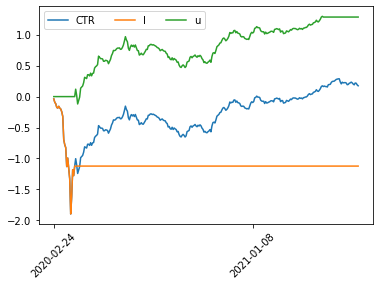

c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


target: EVX
name: MGEE lag: -1 corr: -0.21228274299911845 p-value: 0.00016217320395401632
                 EVX         l         u
2021-07-20  0.189538  0.247317 -0.123704


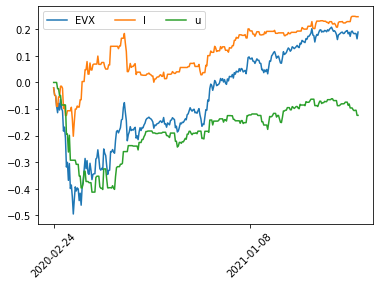

target: EVX
name: JNJ lag: -1 corr: -0.2110662573628468 p-value: 0.00017716457289301398
                 EVX         l         u
2021-07-20  0.189538  0.446226 -0.288704


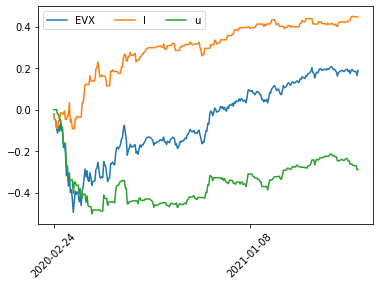

c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


target: STAA
name: CPIAUCSL lag: -19 corr: 0.13237753755320888 p-value: 0.023437011509822442
                STAA         l         u
2021-06-23  1.489025 -0.292444  1.757238


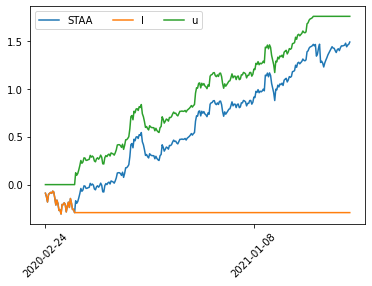

target: TTMI
name: FEDFUNDS lag: -50 corr: -0.19092803429181504 p-value: 0.0019074941156550938
                TTMI         l         u
2021-05-05  0.039294  0.227046 -0.292999


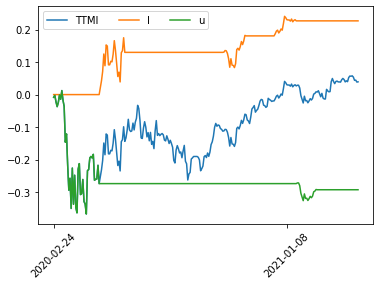

target: GSV
name: UCC lag: -59 corr: -0.15067930765913123 p-value: 0.01646045358324263
                 GSV         l         u
2021-04-22  0.495947  1.021459 -0.543056


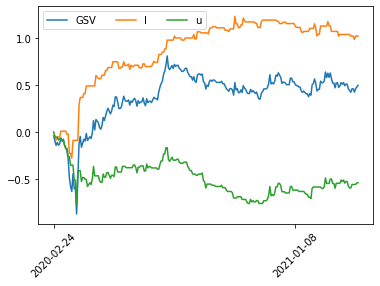

target: GSV
name: UNH lag: -39 corr: -0.13207036268445907 p-value: 0.02913069901637005
                 GSV         l         u
2021-05-24  0.487867  1.365774 -0.820008


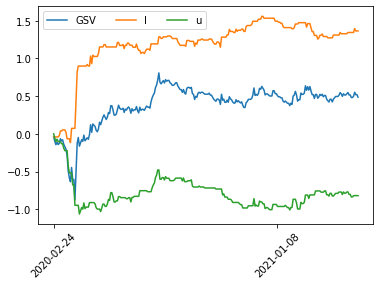

c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


target: PLAG
name: UNH lag: -3 corr: -0.11822294968692572 p-value: 0.03779818366523752
                PLAG         l         u
2021-07-16  0.514968  1.402356 -0.868644


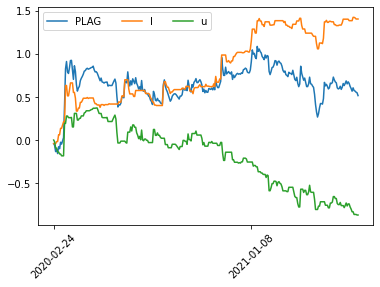

target: ALL
name: MMYT lag: -36 corr: 0.17183101730911374 p-value: 0.004195971452363034
                 ALL        l         u
2021-05-28  0.165767 -0.33485  0.455001


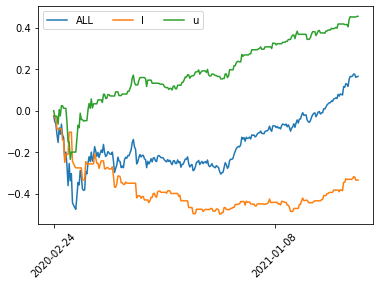

c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


target: KRC
name: FEDFUNDS lag: -48 corr: -0.19047929696301874 p-value: 0.0018788201277105945
                 KRC        l        u
2021-05-07 -0.225524  0.26235 -0.26603


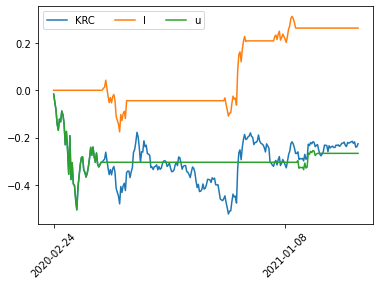

c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


target: MYD
name: ASC lag: -26 corr: -0.1169393527241032 p-value: 0.04818348170136548
                 MYD         l         u
2021-06-14 -0.026512  0.037777 -0.071189


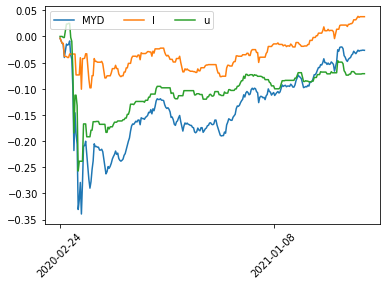

target: REK
name: MABMM301USM189S lag: -33 corr: 0.1257785245807947 p-value: 0.035743842437548266
                 REK    l         u
2021-06-03 -0.081673  0.0  0.045594


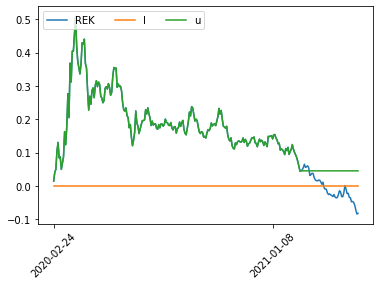

c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


target: VTR
name: CAT lag: -14 corr: -0.13479767193671063 p-value: 0.0199215098571802
                VTR         l         u
2021-06-30  0.24408  0.798857 -0.549204


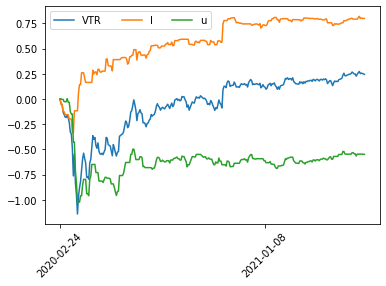

c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


target: UCC
name: IRLTLT01USM156N lag: -5 corr: 0.15743438155841186 p-value: 0.005701350224583144
                 UCC         l        u
2021-07-14  0.478553 -0.369456  0.73847


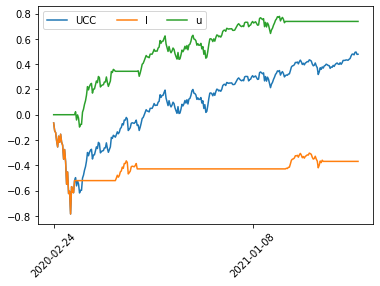

target: SO
name: NBY lag: -23 corr: -0.2663385022508275 p-value: 4.404292571649384e-06
                  SO         l         u
2021-06-17 -0.035178  0.401207 -0.181458


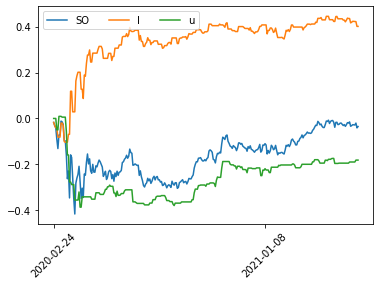

target: EUFN
name: SO lag: -1 corr: -0.14992734916433142 p-value: 0.008088904731876675
                EUFN         l         u
2021-07-20 -0.047302  0.095362 -0.142539


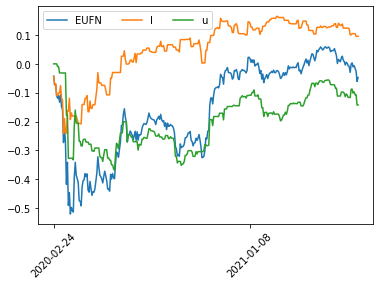

target: GCV
name: DFII10 lag: -53 corr: 0.18732507866258513 p-value: 0.002470185036276558
                 GCV         l         u
2021-04-30  0.140654 -0.127289  0.376857


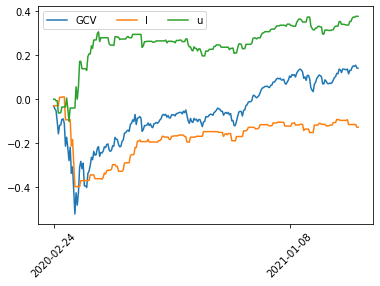

target: STAR
name: IRLTLT01USM156N lag: -9 corr: 0.1393669212040069 p-value: 0.015191645491486223
                STAR        l        u
2021-07-08  0.495048 -0.55816  0.80448


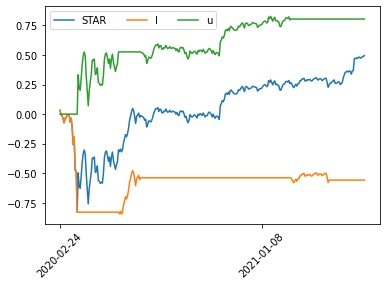

c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


target: DJP
name: PPIACO lag: -6 corr: 0.14920210628719868 p-value: 0.008950575827259437
                 DJP         l         u
2021-07-13  0.185073 -0.244756  0.399073


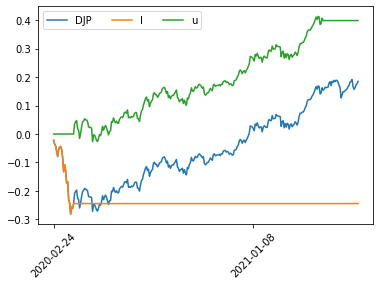

target: DJP
name: CPIAUCSL lag: -6 corr: 0.13430968147629535 p-value: 0.018748016644474855
                 DJP         l        u
2021-07-13  0.185073 -0.248314  0.40263


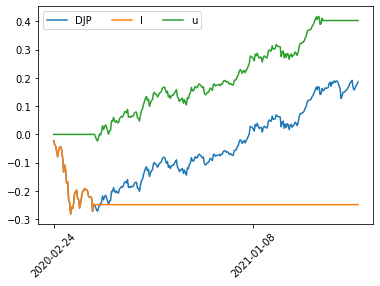

c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


target: SLCT
name: EZU lag: -44 corr: 0.12621796505470043 p-value: 0.03893398364327205
                SLCT         l         u
2021-05-13  0.083144 -0.253349  0.283292


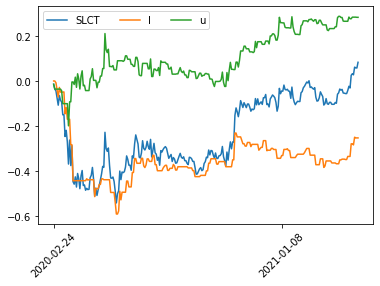

c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


target: HYLD
name: PPIACO lag: -5 corr: 0.2354078396796624 p-value: 3.092375426935342e-05
                HYLD         l         u
2021-07-14  0.003095 -0.310709  0.299269


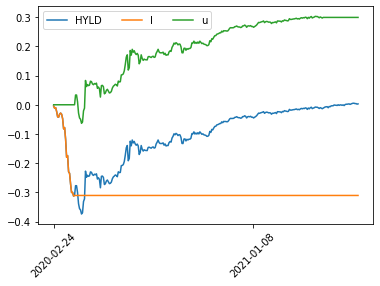

target: HYLD
name: CPIAUCSL lag: -5 corr: 0.23750735789208588 p-value: 2.613016341806076e-05
                HYLD         l         u
2021-07-14  0.003095 -0.239773  0.228333


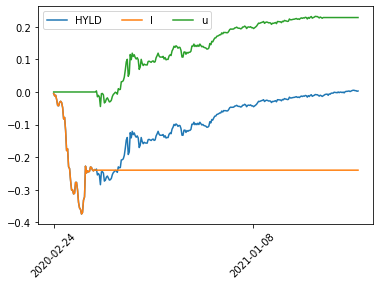

c:\users\user\appdata\local\programs\python\python39\jupyterlab\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [29]:
lagn=63

final = pd.DataFrame()

for target in set(deltas.columns) & set(vetted_symbols):
    #print(f"target: {target}")
    
    #sets = range(0,len(Training),252)
    #move this outside
    X_train = deltas.loc[train][set(deltas.columns).difference(target)].copy()
    X_valid = deltas.loc[test][set(deltas.columns).difference(target)].copy()
    y_train = deltas.loc[train][target].copy()
    y_valid = deltas.loc[test][target].copy()
    
    chosen = pd.DataFrame()
    
    for m in X_train.columns:

        #train
        setc = crosscorrelation(np.array(X_train[m]),np.array(y_train), lagn)
        lag = pd.DataFrame(abs(setc)).idxmax()
        #print(f"correlation: {setc[lag]}")
        temp = pd.concat([X_train[m].shift((lag-lagn)[0]),y_train], axis=1).dropna()
        pearson_coef, p_value = stats.pearsonr(np.array(temp.iloc[:,0]),np.array(temp.iloc[:,1])) #define the columns to perform calculations on
        if (p_value < .05) and ((lag-lagn)[0] < 0):
            #print(i)
            #print(f"lag: {lag-lagn}")
            #print("Pearson Correlation Coefficient: ", pearson_coef, "and a P-value of:", p_value) # Results
            temp1 = pd.DataFrame([target, m,(lag-lagn)[0],pearson_coef]).T
            temp1.columns = ["target","name","lag","pearson"]
            chosen = pd.concat([temp1,chosen],axis=0)
            
    for i in range(0,len(chosen)):
        values = chosen.reset_index().iloc[i]
        name = values['name']
        target = values['target']
        lag = values['lag']
        #print(lag)
        aggregate = pd.DataFrame()

        #test
        innerSet = pd.concat([X_valid[name].shift(lag),y_valid],axis=1).dropna()

        for p in range(0,len(innerSet)):     
            #print(innerSet.iloc[p][name] )
            if(innerSet.iloc[p][name] < 0):
                d = pd.DataFrame([innerSet.index[p].strftime('%Y-%m-%d'),innerSet.iloc[p][target], np.nan, 'l'])
                #print("lower")
            elif (innerSet.iloc[p][name] > 0):
                d = pd.DataFrame([innerSet.index[p].strftime('%Y-%m-%d'),np.nan, innerSet.iloc[p][target], 'u'])
                #print("upper")
            else:
                d = pd.DataFrame([innerSet.index[p].strftime('%Y-%m-%d'),np.nan, np.nan, np.nan])

            aggregate = pd.concat([d.T,aggregate],axis=0)
        #print(aggregate.loc[:,['l','u']].replace([np.inf, -np.inf, np.NaN], 0).cumsum().iloc[-1])

        aggregate.columns = "Date","l","u","class"

        pearson_coef, p_value = stats.pearsonr(np.array(innerSet.iloc[:,0]),np.array(innerSet.iloc[:,1])) #define the columns to perform calculations on

        #print(f"name: {name}", f"lag: {lag}", f"corr: {innerSet.corr().iloc[0][1]}")
        if p_value < .05 and (values['pearson']*pearson_coef) > 0:

                newData = pd.concat([pd.DataFrame(innerSet[target]).set_index(innerSet[target].index.strftime('%Y-%m-%d')),aggregate.set_index("Date")],axis=1).replace([np.inf, -np.inf, np.NaN], 0)

                if newData[[target,"l","u"]].cumsum().iloc[-1][target] < newData[[target,"l","u"]].cumsum().iloc[-1]['l'] or newData[[target,"l","u"]].cumsum().iloc[-1][target] < newData[[target,"l","u"]].cumsum().iloc[-1]['u']:
                    print(f"target: {target}")
                    print(f"name: {name}", f"lag: {lag}", f"corr: {pearson_coef}", f"p-value: {p_value}")
                    print(pd.DataFrame(newData[[target,"l","u"]].cumsum().iloc[-1]).T)

                    x_ticks = newData.index[np.arange(0, len(newData.index), 200)]

                    plt.plot(newData[[target,"l","u"]].cumsum())
                    plt.legend(loc='upper left', fancybox=True, ncol=5, labels=[target,"l","u"])
                    #plt.legend(loc="upper left",fontsize=8)

                    plt.xticks(x_ticks, rotation = 45)
                    plt.show()
                    
                    temp1 = pd.DataFrame([target, name, pearson_coef, p_value, lag, max(newData[[target,"l","u"]].cumsum().iloc[-1][['l','u']]), newData[[target]].cumsum().iloc[-1][target] ]).T
                    final = pd.concat([temp1,final],axis=0)

final.columns = ["target","correlate","pearson","p-value","lag","TCR","holdTCR"]


In [30]:
final

,target,correlate,pearson,p-value,lag,TCR,holdTCR
0,HYLD,CPIAUCSL,0.237507,0.000026,-5,0.228333,0.003095
0,HYLD,PPIACO,0.235408,0.000031,-5,0.299269,0.003095
0,SLCT,EZU,0.126218,0.038934,-44,0.283292,0.083144
0,DJP,CPIAUCSL,0.13431,0.018748,-6,0.40263,0.185073
0,DJP,PPIACO,0.149202,0.008951,-6,0.399073,0.185073
0,STAR,IRLTLT01USM156N,0.139367,0.015192,-9,0.80448,0.495048
0,GCV,DFII10,0.187325,0.00247,-53,0.376857,0.140654
0,EUFN,SO,-0.149927,0.008089,-1,0.095362,-0.047302
0,SO,NBY,-0.266339,0.000004,-23,0.401207,-0.035178
0,UCC,IRLTLT01USM156N,0.157434,0.005701,-5,0.73847,0.478553


target: HYLD
name: CPIAUCSL lag: -5 corr: 0.23750735789208588 p-value: 2.613016341806076e-05
                HYLD         l         u
2021-07-14  0.003095 -0.239773  0.228333


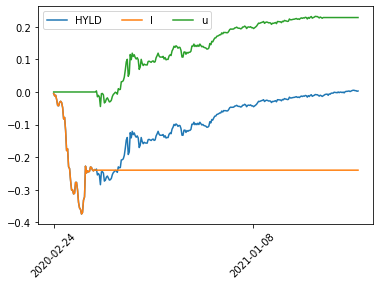

target: HYLD
name: PPIACO lag: -5 corr: 0.2354078396796624 p-value: 3.092375426935342e-05
                HYLD         l         u
2021-07-14  0.003095 -0.310709  0.299269


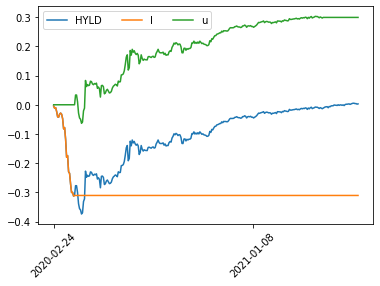

target: SLCT
name: EZU lag: -44 corr: 0.12621796505470043 p-value: 0.03893398364327205
                SLCT         l         u
2021-05-13  0.083144 -0.253349  0.283292


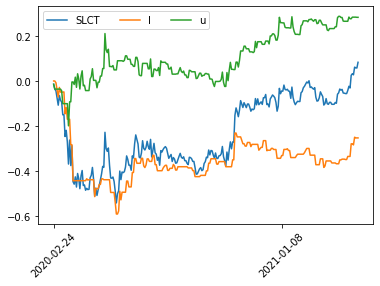

target: DJP
name: CPIAUCSL lag: -6 corr: 0.13430968147629535 p-value: 0.018748016644474855
                 DJP         l        u
2021-07-13  0.185073 -0.248314  0.40263


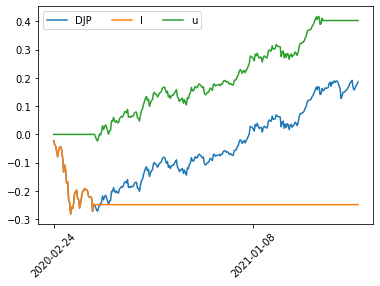

target: DJP
name: PPIACO lag: -6 corr: 0.14920210628719868 p-value: 0.008950575827259437
                 DJP         l         u
2021-07-13  0.185073 -0.244756  0.399073


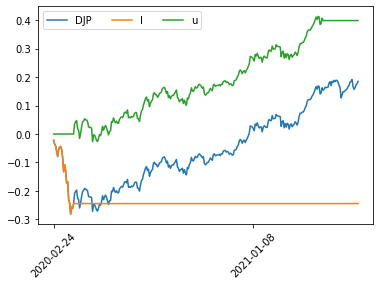

target: STAR
name: IRLTLT01USM156N lag: -9 corr: 0.1393669212040069 p-value: 0.015191645491486223
                STAR        l        u
2021-07-08  0.495048 -0.55816  0.80448


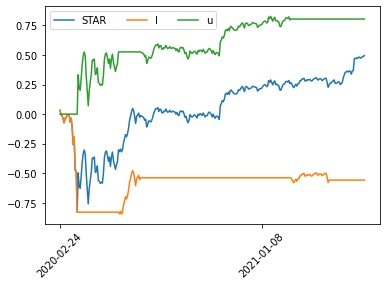

target: GCV
name: DFII10 lag: -53 corr: 0.18732507866258513 p-value: 0.002470185036276558
                 GCV         l         u
2021-04-30  0.140654 -0.127289  0.376857


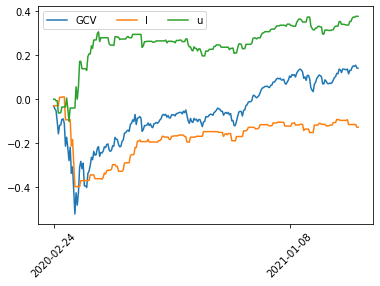

target: EUFN
name: SO lag: -1 corr: -0.14992734916433142 p-value: 0.008088904731876675
                EUFN         l         u
2021-07-20 -0.047302  0.095362 -0.142539


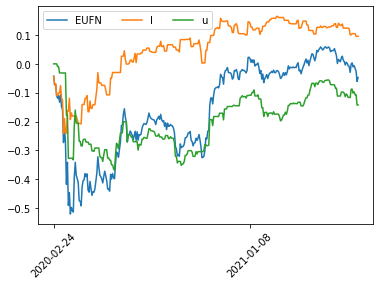

target: SO
name: NBY lag: -23 corr: -0.2663385022508275 p-value: 4.404292571649384e-06
                  SO         l         u
2021-06-17 -0.035178  0.401207 -0.181458


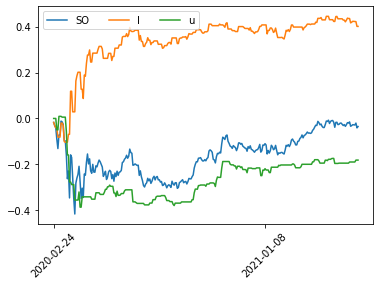

target: UCC
name: IRLTLT01USM156N lag: -5 corr: 0.15743438155841186 p-value: 0.005701350224583144
                 UCC         l        u
2021-07-14  0.478553 -0.369456  0.73847


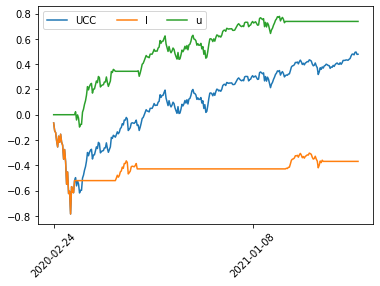

target: VTR
name: CAT lag: -14 corr: -0.13479767193671063 p-value: 0.0199215098571802
                VTR         l         u
2021-06-30  0.24408  0.798857 -0.549204


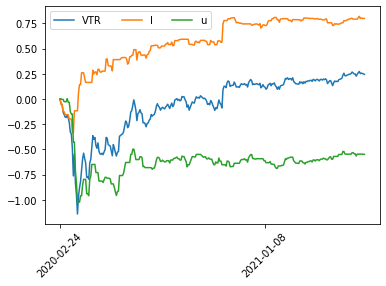

target: REK
name: MABMM301USM189S lag: -33 corr: 0.1257785245807947 p-value: 0.035743842437548266
                 REK    l         u
2021-06-03 -0.081673  0.0  0.045594


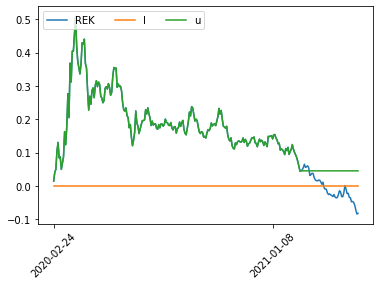

target: MYD
name: ASC lag: -26 corr: -0.1169393527241032 p-value: 0.04818348170136548
                 MYD         l         u
2021-06-14 -0.026512  0.037777 -0.071189


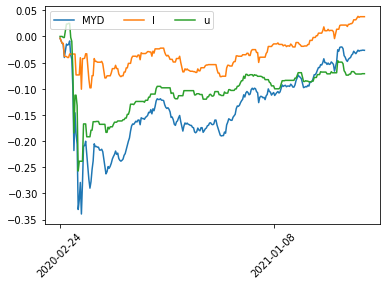

target: KRC
name: FEDFUNDS lag: -48 corr: -0.19047929696301874 p-value: 0.0018788201277105945
                 KRC        l        u
2021-05-07 -0.225524  0.26235 -0.26603


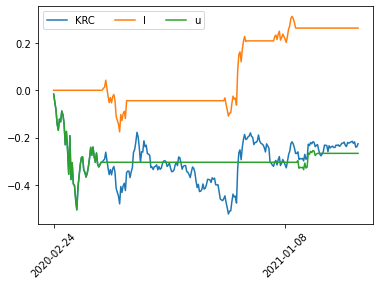

target: ALL
name: MMYT lag: -36 corr: 0.17183101730911374 p-value: 0.004195971452363034
                 ALL        l         u
2021-05-28  0.165767 -0.33485  0.455001


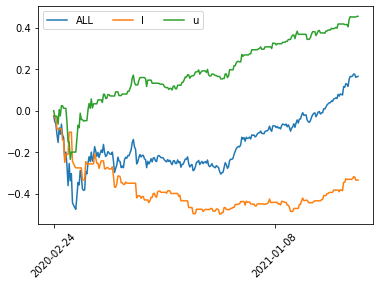

target: PLAG
name: UNH lag: -3 corr: -0.11822294968692572 p-value: 0.03779818366523752
                PLAG         l         u
2021-07-16  0.514968  1.402356 -0.868644


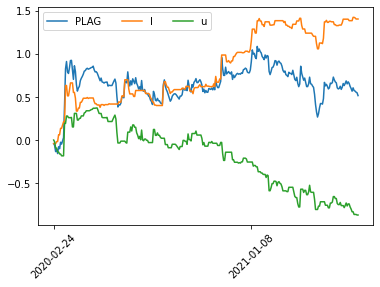

target: GSV
name: UNH lag: -39 corr: -0.13207036268445907 p-value: 0.02913069901637005
                 GSV         l         u
2021-05-24  0.487867  1.365774 -0.820008


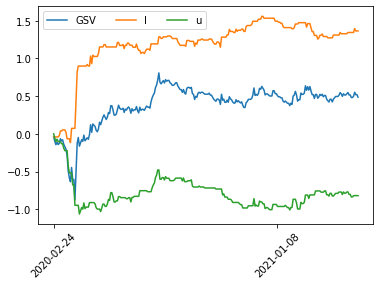

target: GSV
name: UCC lag: -59 corr: -0.15067930765913123 p-value: 0.01646045358324263
                 GSV         l         u
2021-04-22  0.495947  1.021459 -0.543056


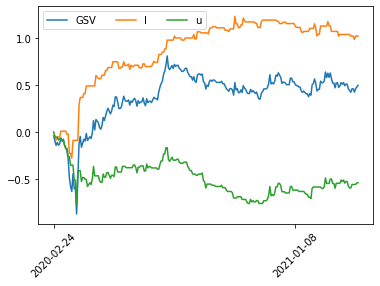

target: TTMI
name: FEDFUNDS lag: -50 corr: -0.19092803429181504 p-value: 0.0019074941156550938
                TTMI         l         u
2021-05-05  0.039294  0.227046 -0.292999


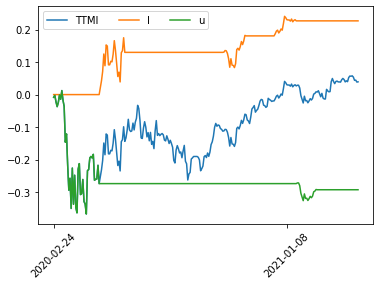

target: STAA
name: CPIAUCSL lag: -19 corr: 0.13237753755320888 p-value: 0.023437011509822442
                STAA         l         u
2021-06-23  1.489025 -0.292444  1.757238


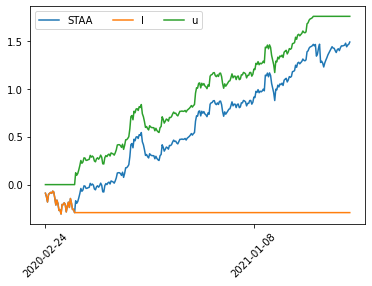

target: EVX
name: JNJ lag: -1 corr: -0.2110662573628468 p-value: 0.00017716457289301398
                 EVX         l         u
2021-07-20  0.189538  0.446226 -0.288704


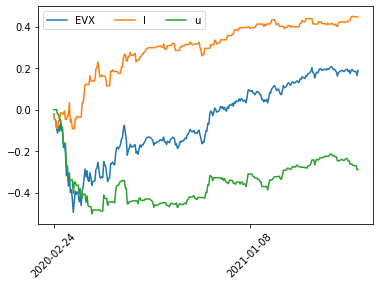

target: EVX
name: MGEE lag: -1 corr: -0.21228274299911845 p-value: 0.00016217320395401632
                 EVX         l         u
2021-07-20  0.189538  0.247317 -0.123704


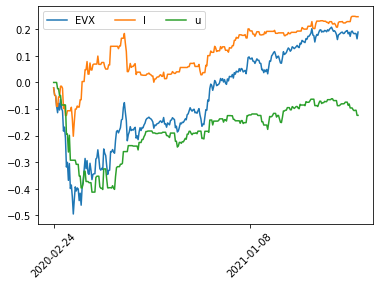

target: CTR
name: PPIACO lag: -5 corr: 0.13799243424502944 p-value: 0.01553990755848175
                 CTR         l         u
2021-07-14  0.174892 -1.122657  1.285202


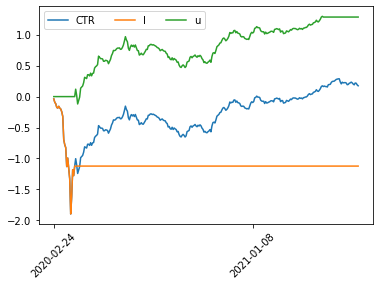

In [31]:
results2 = pd.DataFrame()

for i in range(0,len(final)):
    values = final.reset_index().iloc[i]
    name = values['correlate']
    target = values['target']
    lag = values['lag']
    #print(lag)
    aggregate = pd.DataFrame()

    X_test = deltas.loc[test][set(deltas.columns).difference(target)]
    y_test = deltas.loc[test][target]
    
    #test
    innerSet = pd.concat([X_test[name].shift(lag),y_test],axis=1).dropna()

    for p in range(0,len(innerSet)):     
        #print(innerSet.iloc[p][name] )
        if(innerSet.iloc[p][name] < 0):
            d = pd.DataFrame([innerSet.index[p].strftime('%Y-%m-%d'),innerSet.iloc[p][target], np.nan, 'l'])
            #print("lower")
        elif (innerSet.iloc[p][name] > 0):
            d = pd.DataFrame([innerSet.index[p].strftime('%Y-%m-%d'),np.nan, innerSet.iloc[p][target], 'u'])
            #print("upper")
        else:
            d = pd.DataFrame([innerSet.index[p].strftime('%Y-%m-%d'),np.nan, np.nan, np.nan])

        aggregate = pd.concat([d.T,aggregate],axis=0)
    #print(aggregate.loc[:,['l','u']].replace([np.inf, -np.inf, np.NaN], 0).cumsum().iloc[-1])

    aggregate.columns = "Date","l","u","class"

    pearson_coef, p_value = stats.pearsonr(np.array(innerSet.iloc[:,0]),np.array(innerSet.iloc[:,1])) #define the columns to perform calculations on

    #print(f"name: {name}", f"lag: {lag}", f"corr: {innerSet.corr().iloc[0][1]}")
    if p_value < .05:

            newData = pd.concat([pd.DataFrame(innerSet[target]).set_index(innerSet[target].index.strftime('%Y-%m-%d')),aggregate.set_index("Date")],axis=1).replace([np.inf, -np.inf, np.NaN], 0)

            if newData[[target,"l","u"]].cumsum().iloc[-1][target] < newData[[target,"l","u"]].cumsum().iloc[-1]['l'] or newData[[target,"l","u"]].cumsum().iloc[-1][target] < newData[[target,"l","u"]].cumsum().iloc[-1]['u']:
                print(f"target: {target}")
                print(f"name: {name}", f"lag: {lag}", f"corr: {pearson_coef}", f"p-value: {p_value}")
                print(pd.DataFrame(newData[[target,"l","u"]].cumsum().iloc[-1]).T)

                x_ticks = newData.index[np.arange(0, len(newData.index), 200)]

                plt.plot(newData[[target,"l","u"]].cumsum())
                plt.legend(loc='upper left', fancybox=True, ncol=5, labels=[target,"l","u"])
                #plt.legend(loc="upper left",fontsize=8)

                plt.xticks(x_ticks, rotation = 45)
                plt.show()

                temp1 = pd.DataFrame([target, name, pearson_coef, p_value, lag, max(newData[[target,"l","u"]].cumsum().iloc[-1][['l','u']]), newData[[target]].cumsum().iloc[-1][target] ]).T
                results2 = pd.concat([temp1,results2],axis=0)
                
results2.columns = ["target","correlate","pearson","p-value","lag","TCR","holdTCR"]                

In [32]:
len(final)

23

In [33]:
results2

,target,correlate,pearson,p-value,lag,TCR,holdTCR
0,CTR,PPIACO,0.137992,0.01554,-5,1.285202,0.174892
0,EVX,MGEE,-0.212283,0.000162,-1,0.247317,0.189538
0,EVX,JNJ,-0.211066,0.000177,-1,0.446226,0.189538
0,STAA,CPIAUCSL,0.132378,0.023437,-19,1.757238,1.489025
0,TTMI,FEDFUNDS,-0.190928,0.001907,-50,0.227046,0.039294
0,GSV,UCC,-0.150679,0.01646,-59,1.021459,0.495947
0,GSV,UNH,-0.13207,0.029131,-39,1.365774,0.487867
0,PLAG,UNH,-0.118223,0.037798,-3,1.402356,0.514968
0,ALL,MMYT,0.171831,0.004196,-36,0.455001,0.165767
0,KRC,FEDFUNDS,-0.190479,0.001879,-48,0.26235,-0.225524


In [34]:
pd.concat([final['pearson'],results2['pearson']],axis=1)

,pearson,pearson
0,0.237507,0.137992
0,0.235408,-0.212283
0,0.126218,-0.211066
0,0.13431,0.132378
0,0.149202,-0.190928
0,0.139367,-0.150679
0,0.187325,-0.13207
0,-0.149927,-0.118223
0,-0.266339,0.171831
0,0.157434,-0.190479


In [35]:
pd.concat([final['pearson']*results2['pearson']],axis=1)

,pearson
0,0.032774
0,-0.049973
0,-0.02664
0,0.01778
0,-0.028487
0,-0.021
0,-0.02474
0,0.017725
0,-0.045765
0,-0.029988


In [ ]:
aggregate = pd.DataFrame()

for s in Training:
    #print(s)
    set_dates = s
    #print(set_dates[1])
    #print(set_dates[-1])
    
    #rate of change compare
    filtered2 =  pd.concat([truncatedData.loc[[i[0] for i in set_dates]][compare],truncatedData.loc[[i[0] for i in set_dates]][target]],axis=1).pct_change().dropna().replace([np.inf, -np.inf, np.NaN], 0)
    #quantiles2 = filtered2[compare].quantile(q=[0, .25, .5, .75, 1], interpolation='linear')

    #prop_cycle = plt.rcParams['axes.prop_cycle']
    #colors = cycle(prop_cycle.by_key()['color'])
    
    #subset, Holdout = split_sequences(np.array(pd.DataFrame(filtered2.index.strftime('%Y-%m-%d'))), 126, 0)
    
    #for i in subset:
        
    #quantiles = pd.DataFrame(filtered2.iloc[0:-2][compare].quantile([0,.5,1]),columns=['min','median','max'])
    #np.percentile((filtered2.iloc[0:-2][compare]),50)
    
    t = pd.DataFrame(filtered2.iloc[0:-3][compare].quantile([0,.5,1])).T
    t.columns = ['min','median','max']
    quantiles = t.reset_index(drop=True)

    #lower = filtered2.iloc[0:-1][(filtered2.iloc[0:-2][compare]<=quantile)].index
    #upper = ~filtered2.iloc[0:-2].index.isin(lower)



    #my_dpi = 100
    #fig, axes = plt.subplots(figsize=(12, 4),ncols=3, nrows=1)
    #ax1, ax2, ax3 = axes.ravel()
    #sns.set(style="ticks")
    #sns.despine(fig=fig)

    #dataframe = filtered2.loc[dates]
    #returns = dataframe[target].dropna()

    #l = np.where(filtered2.iloc[0:-2][compare] <= quantile, filtered2.iloc[-1][target], 0)
    #u = np.where(filtered2.iloc[upper][compare] > quantile, filtered2.iloc[-1][target], 0)
    if((filtered2.iloc[-2][compare] <= quantiles['median'][0])):
        d = pd.DataFrame([filtered2.iloc[-1][target], np.nan, 'l'])
    else:
        d = pd.DataFrame([np.nan, filtered2.iloc[-1][target], 'u'])
    #d = pd.concat([pd.DataFrame(l.tolist()),pd.DataFrame(u.tolist())],axis=1)
    #print(len(d))
    #print(d)
    
    #print(pd.concat([d.T, quantiles.T.reset_index(drop=True)],axis=1))
    #aggregate = pd.concat([d.T, quantiles.T.reset_index(drop=True), aggregate],axis=0)
    aggregate = pd.concat([pd.concat([d.T, quantiles],axis=1),aggregate],axis=0)
    #print(aggregate)
    #print(len(aggregate))
    #print(aggregate)
    #d.index = filtered2.iloc[-1].name.strftime('%Y-%m-%d')
   
    #sns.regplot(x=compare, y=target, data=dataframe, ax=ax1)

    #sns.violinplot(x=dataframe[compare].dropna(),color=next(colors), ax=ax2)

    #sns.vioinplot(x=returns,color=next(colors), ax=ax3) 
    #plt.show()




In [ ]:
len(Training)

aggregate.columns = ['l','u','class','min','median','max']

dates = []
for item in Training:
    last = item[-1]
    dates.append(last[0])
    
aggregate.loc[:,['l','u']].replace([np.inf, -np.inf, np.NaN], 0).cumsum().iloc[-1]

aggregate.index=dates

#print(aggregate.cumsum().iloc[-1])
#aggregate.reset_index()
#ax = sns.regplot(x=aggregate.columns[1], y='index', data=aggregate.reset_index())

x_ticks = aggregate.index[np.arange(0, len(aggregate.index), 200)]

plt.plot(aggregate.loc[:,['l']].replace([np.inf, -np.inf, np.NaN], 0).cumsum())

plt.xticks(x_ticks, rotation = 45)
plt.show()

In [ ]:
temp1 = pd.concat([truncatedData[compare].pct_change(),truncatedData[target]],axis=1).loc[dates]
temp2 = pd.concat([truncatedData[compare].pct_change(),truncatedData[target].pct_change()],axis=1).loc[dates]
temp1.index = temp1.index.copy().strftime('%Y-%m-%d')
temp2.index = temp2.index.copy().strftime('%Y-%m-%d')
temp = pd.concat([temp1,temp2,aggregate],axis=1)
newNames = [compare,target,compare+"_pct_change",target+"_pct_change"]
newNames.extend(temp.columns[4:10])
temp.columns = newNames

temp.to_csv('../data/processed/output.csv', index=True) 

In [ ]:
from sklearn import metrics
#scores = np.where(temp[compare] > 1, 1, 0)

#idk why this library uses 2, 1 vs 1 and 0
fpr, tpr, thresholds = metrics.roc_curve(np.where(temp[target+"_pct_change"] > 0, 2, 1), np.array(temp[compare+"_pct_change"].shift(-1)) , pos_label=2)

In [ ]:
metrics.plot_roc_curve(clf, X_test, y_test)  

In [ ]:
from sklearn.metrics import roc_curve
#plt.plot(fpr,tpr, label='AUC = ' + str(round(roc_auc_score(y,m.oob_decision_function_[:,1]), 2)))
#plt.legend(loc='lower right')

from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(np.where(temp[target+"_pct_change"] > 0, 1, 0), np.array(temp[compare+"_pct_change"]), labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

In [ ]:


print("optimal cutoff")
#https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
Find_Optimal_Cutoff(np.where(temp[target+"_pct_change"] > 0, 1, 0), np.array(temp[compare+"_pct_change"]))


In [ ]:
from kneed import DataGenerator, KneeLocator
kneedle = KneeLocator(fpr, tpr, S=1.0, curve="concave", direction="increasing")
#kneedle.plot_knee_normalized()
kneedle.plot_knee()

In [ ]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]


In [ ]:
plt.scatter(aggregate[aggregate['bifur']=='l'].iloc[:,0].cumsum(),  truncatedData[target].pct_change().loc[aggregate[aggregate['bifur']=='l'].iloc[:,0].index.tolist()])
plt.show()
aggregate[aggregate['bifur']=='l'].iloc[:,0].hist()
plt.show()

In [ ]:
plt.scatter(aggregate[aggregate['bifur']=='u'].iloc[:,1].cumsum(),  truncatedData[target].pct_change().loc[aggregate[aggregate['bifur']=='u'].iloc[:,1].index.tolist()])
plt.show()
aggregate[aggregate['bifur']=='u'].iloc[:,1].hist()
plt.show()

In [ ]:
#252 trading days a year
#30 days = 21
#60 = 42
#90 = 63

#return = current - prior / prior

#for i in range(1,63): #[1,21,42,63]
for i in [1,21,42,63,84]: #[1,21,42,84]
    print(i)
    rate_of_change = (truncatedData[compare]-truncatedData[compare].shift(i))/truncatedData[compare].shift(i)
    
    newDF = pd.concat([rate_of_change,truncatedData[target].pct_change()],axis=1).dropna()

    set1 = newDF[compare]
    set2 = newDF[target]
    
    lags = range(0,85) #[0,21,42,63]
    mcorrs_ = []
    mlags = []
    for j in lags:
        
        newSet = pd.concat([set1.shift(j),set2],axis=1).dropna()
      
        mcorrs_.append(np.array(newSet.corr())[1,0])
        
    plt.plot(mcorrs_)
    plt.show()





In [ ]:
pd.concat([(truncatedData[compare]-truncatedData[compare].shift(1))/truncatedData[compare].shift(1),truncatedData[target].pct_change().shift(0)],axis=1).dropna().corr()

In [ ]:
plt.scatter((truncatedData[compare]-truncatedData[compare].shift(1))/truncatedData[compare].shift(1),truncatedData[target].pct_change().shift(0))

In [ ]:
#import matplotlib.pyplot as plt
#plt.matshow(
df = combined_set.loc[combined_set.index>=start_date.strftime('%Y-%m-%d')]

r_ = df.corr()

filter = r_[compare]
                       
filter = filter[filter<1]
filter = filter.sort_values(kind="quicksort", ascending=True)
print(filter.head(10))
print(filter.tail(10))
